In [5]:
# !pip install eli5
# !pip install imblearn
# !pip install s3fs
# !pip install tldextract -q
# !pip install tldextract
# !pip install nltk
# !pip install lightgbm
# !pip install xgboost
# !pip install s3fs


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 30.4 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [13]:
# Importing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
# from keras.models import Sequential
# from keras.layers import Dense
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from imblearn.under_sampling import RandomUnderSampler
# from keras.layers import Activation, Dense, Flatten 
from typing import *
import random
from sklearn.tree import DecisionTreeRegressor
import sys
import os

import tldextract
import seaborn as sns 
import warnings
import regex as re
import eli5
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer

In [16]:
df = pd.read_csv('s3://saif.cloudassignment1/phishing_site_urls.csv')

In [18]:
df.head()
url_data = df
url_data

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


# Preprocessing
Including: 
1. Feature Extraction
2. Random OverSampling
3. SMOTE Oversampling
4. Feature Selection

In [19]:
url_data = url_data.rename(columns={"URL": "url", "Label": "label"})
url_data

,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


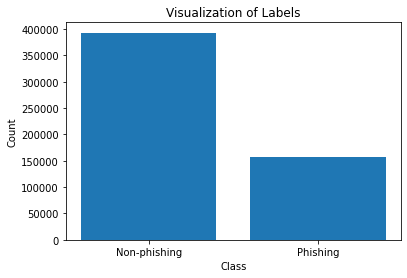

Number of Phishing URLs:  156422
Number of non-phishing URLs:  392924


In [20]:
# Checking for balance in our data

counts = url_data.value_counts(url_data.label, sort=True)
classes = url_data.label.unique()
plt.bar(['Non-phishing','Phishing'], counts)

plt.title('Visualization of Labels')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

print('Number of Phishing URLs: ', len(url_data[url_data['label']== 'bad']))
print('Number of non-phishing URLs: ', len(url_data[url_data['label']== 'good']))

# This means that our classes are imbalanced as expected.

In [21]:
url_data['label'] = url_data['label'].replace({"good": 0, "bad": 1})

In [22]:
def parse_url(url: str) -> Optional[Dict[str, str]]:
    
    try:
        no_scheme = not url.startswith('https://') and not url.startswith('http://')
        if no_scheme:
            parsed_url = urlparse(f"http://{url}")
            
            return {
                "scheme": None, # not established a value for this
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
        else:
            parsed_url = urlparse(url)
            return {
                "scheme": parsed_url.scheme,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
    except:
        return None

In [23]:
url_data["parsed_url"] = url_data.url.apply(parse_url)
url_data

,url,label,parsed_url
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,"{'scheme': None, 'netloc': 'nobell.it', 'path'..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,"{'scheme': None, 'netloc': 'www.dghjdgf.com', ..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,"{'scheme': None, 'netloc': 'serviciosbys.com',..."
3,mail.printakid.com/www.online.americanexpress....,1,"{'scheme': None, 'netloc': 'mail.printakid.com..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,"{'scheme': None, 'netloc': 'thewhiskeydregs.co..."
...,...,...,...
549341,23.227.196.215/,1,"{'scheme': None, 'netloc': '23.227.196.215', '..."
549342,apple-checker.org/,1,"{'scheme': None, 'netloc': 'apple-checker.org'..."
549343,apple-iclods.org/,1,"{'scheme': None, 'netloc': 'apple-iclods.org',..."
549344,apple-uptoday.org/,1,"{'scheme': None, 'netloc': 'apple-uptoday.org'..."


In [24]:
url_data.dropna(inplace=True)

In [25]:
def dd(url_info):
        scheme , netloc , path , params , query , fragment = [],[],[],[],[],[]
        for i in url_info.values:   
                l = list(i.values())
                scheme.append(l[0])
                netloc.append(l[1])
                path.append(l[2])
                params.append(l[3])
                query.append(l[4])
                fragment.append(l[5])
        return pd.DataFrame({"scheme":scheme , "netloc":netloc , "path":path , "params":params , "query":query , "fragment":fragment})

                
                

                


# url_data['parsed_url'].apply(dd)

In [26]:
url_data

,url,label,parsed_url
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,"{'scheme': None, 'netloc': 'nobell.it', 'path'..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,"{'scheme': None, 'netloc': 'www.dghjdgf.com', ..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,"{'scheme': None, 'netloc': 'serviciosbys.com',..."
3,mail.printakid.com/www.online.americanexpress....,1,"{'scheme': None, 'netloc': 'mail.printakid.com..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,"{'scheme': None, 'netloc': 'thewhiskeydregs.co..."
...,...,...,...
549341,23.227.196.215/,1,"{'scheme': None, 'netloc': '23.227.196.215', '..."
549342,apple-checker.org/,1,"{'scheme': None, 'netloc': 'apple-checker.org'..."
549343,apple-iclods.org/,1,"{'scheme': None, 'netloc': 'apple-iclods.org',..."
549344,apple-uptoday.org/,1,"{'scheme': None, 'netloc': 'apple-uptoday.org'..."


In [27]:
url_data.reset_index(drop=True,inplace=True)

In [29]:
url_data = pd.concat( [url_data.drop(['parsed_url'],axis=1),
dd(url_data["parsed_url"])],axis=1 )

In [30]:
url_data = url_data[~url_data.netloc.isnull()]
url_data

,url,label,scheme,netloc,path,params,query,fragment
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,None,nobell.it,/70ffb52d079109dca5664cce6f317373782/login.Sky...,,cmd=_profile-ach&outdated_page_tmpl=p/gen/fail...,
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,None,www.dghjdgf.com,/paypal.co.uk/cycgi-bin/webscrcmd=_home-custom...,,,
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,None,serviciosbys.com,/paypal.cgi.bin.get-into.herf.secure.dispatch3...,,,
3,mail.printakid.com/www.online.americanexpress....,1,None,mail.printakid.com,/www.online.americanexpress.com/index.html,,,
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,None,thewhiskeydregs.com,/wp-content/themes/widescreen/includes/temp/pr...,,84784787824HDJNDJDSJSHD//2724782784/,
...,...,...,...,...,...,...,...,...
549328,23.227.196.215/,1,None,23.227.196.215,/,,,
549329,apple-checker.org/,1,None,apple-checker.org,/,,,
549330,apple-iclods.org/,1,None,apple-iclods.org,/,,,
549331,apple-uptoday.org/,1,None,apple-uptoday.org,/,,,


In [31]:
url_data["length"] = url_data.url.str.len()

In [32]:
url_data["tld"] = url_data.netloc.apply(lambda nl: tldextract.extract(nl).suffix)
url_data['tld'] = url_data['tld'].replace('','None')

In [33]:
url_data["is_ip"] = url_data.netloc.str.fullmatch(r"\d+\.\d+\.\d+\.\d+")

In [34]:
url_data['domain_hyphens'] = url_data.netloc.str.count('-')
url_data['domain_underscores'] = url_data.netloc.str.count('_')
url_data['path_hyphens'] = url_data.path.str.count('-')
url_data['path_underscores'] = url_data.path.str.count('_')
url_data['slashes'] = url_data.path.str.count('/')

In [35]:
url_data['full_stops'] = url_data.path.str.count('.')

In [36]:
def get_num_subdomains(netloc: str) -> int:
    subdomain = tldextract.extract(netloc).subdomain 
    if subdomain == "":
        return 0
    return subdomain.count('.') + 1

url_data['num_subdomains'] = url_data['netloc'].apply(lambda net: get_num_subdomains(net))

In [37]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
def tokenize_domain(netloc: str) -> str:
    split_domain = tldextract.extract(netloc)
    no_tld = str(split_domain.subdomain +'.'+ split_domain.domain)
    return " ".join(map(str,tokenizer.tokenize(no_tld)))
         
url_data['domain_tokens'] = url_data['netloc'].apply(lambda net: tokenize_domain(net))

In [38]:
url_data['path_tokens'] = url_data['path'].apply(lambda path: " ".join(map(str,tokenizer.tokenize(path))))

In [39]:
url_data_y = url_data['label']
url_data.drop('label', axis=1, inplace=True)
url_data.drop('url', axis=1, inplace=True)
url_data.drop('scheme', axis=1, inplace=True)
url_data.drop('netloc', axis=1, inplace=True)
url_data.drop('path', axis=1, inplace=True)
url_data.drop('params', axis=1, inplace=True)
url_data.drop('query', axis=1, inplace=True)
url_data.drop('fragment', axis=1, inplace=True)
url_data

,length,tld,is_ip,domain_hyphens,domain_underscores,path_hyphens,path_underscores,slashes,full_stops,num_subdomains,domain_tokens,path_tokens
0,225,it,False,0,0,1,0,8,125,0,nobell,ffb d dca cce f login SkyPe com en cgi bin ver...
1,81,com,False,0,0,2,1,4,66,1,www dghjdgf,paypal co uk cycgi bin webscrcmd home customer...
2,177,com,False,0,0,1,0,11,161,0,serviciosbys,paypal cgi bin get into herf secure dispatch r...
3,60,com,False,0,0,0,0,2,42,1,mail printakid,www online americanexpress com index html
4,116,com,False,0,0,1,0,7,60,0,thewhiskeydregs,wp content themes widescreen includes temp pro...
...,...,...,...,...,...,...,...,...,...,...,...,...
549328,15,None,True,0,0,0,0,1,1,0,,
549329,18,org,False,1,0,0,0,1,1,0,apple checker,
549330,17,org,False,1,0,0,0,1,1,0,apple iclods,
549331,18,org,False,1,0,0,0,1,1,0,apple uptoday,


In [40]:
url_data

,length,tld,is_ip,domain_hyphens,domain_underscores,path_hyphens,path_underscores,slashes,full_stops,num_subdomains,domain_tokens,path_tokens
0,225,it,False,0,0,1,0,8,125,0,nobell,ffb d dca cce f login SkyPe com en cgi bin ver...
1,81,com,False,0,0,2,1,4,66,1,www dghjdgf,paypal co uk cycgi bin webscrcmd home customer...
2,177,com,False,0,0,1,0,11,161,0,serviciosbys,paypal cgi bin get into herf secure dispatch r...
3,60,com,False,0,0,0,0,2,42,1,mail printakid,www online americanexpress com index html
4,116,com,False,0,0,1,0,7,60,0,thewhiskeydregs,wp content themes widescreen includes temp pro...
...,...,...,...,...,...,...,...,...,...,...,...,...
549328,15,None,True,0,0,0,0,1,1,0,,
549329,18,org,False,1,0,0,0,1,1,0,apple checker,
549330,17,org,False,1,0,0,0,1,1,0,apple iclods,
549331,18,org,False,1,0,0,0,1,1,0,apple uptoday,


In [41]:
clone = pd.concat([url_data, url_data_y], axis=1)
clone

,length,tld,is_ip,domain_hyphens,domain_underscores,path_hyphens,path_underscores,slashes,full_stops,num_subdomains,domain_tokens,path_tokens,label
0,225,it,False,0,0,1,0,8,125,0,nobell,ffb d dca cce f login SkyPe com en cgi bin ver...,1
1,81,com,False,0,0,2,1,4,66,1,www dghjdgf,paypal co uk cycgi bin webscrcmd home customer...,1
2,177,com,False,0,0,1,0,11,161,0,serviciosbys,paypal cgi bin get into herf secure dispatch r...,1
3,60,com,False,0,0,0,0,2,42,1,mail printakid,www online americanexpress com index html,1
4,116,com,False,0,0,1,0,7,60,0,thewhiskeydregs,wp content themes widescreen includes temp pro...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549328,15,None,True,0,0,0,0,1,1,0,,,1
549329,18,org,False,1,0,0,0,1,1,0,apple checker,,1
549330,17,org,False,1,0,0,0,1,1,0,apple iclods,,1
549331,18,org,False,1,0,0,0,1,1,0,apple uptoday,,1


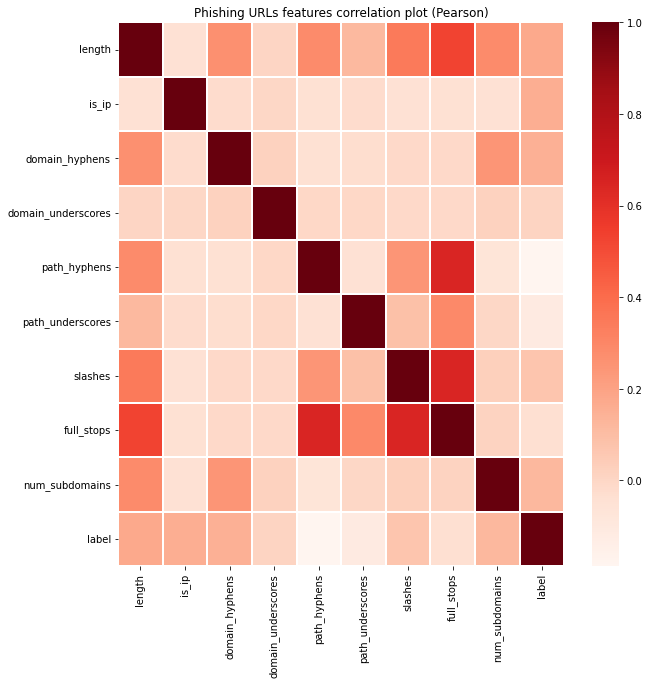

In [42]:
# Checking for correlation between features
plt.figure(figsize = (10,10))
plt.title('Phishing URLs features correlation plot (Pearson)')
corr = clone.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [43]:
#  Splitting our data

numeric_features = ['length', 'domain_hyphens', 'domain_underscores', 'path_hyphens', 'path_underscores', 'slashes', 'full_stops', 'num_subdomains']
url_data= url_data[numeric_features]
X_train, X_test, y_train, y_test = train_test_split(url_data, url_data_y, test_size=0.33, random_state=42)

## Oversampling

In [44]:
# Random Oversampling

print('Original dataset shape %s' % Counter(y_train))
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print('Randomly oversampled dataset shape %s' % Counter(y_train_ros))

Original dataset shape Counter({0: 263235, 1: 104818})
Randomly oversampled dataset shape Counter({0: 263235, 1: 263235})


In [45]:
# SMOTE Oversampling

print('Original dataset shape %s' % Counter(y_train))
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print('SMOTE oversampled dataset shape %s' % Counter(y_train_smote))

Original dataset shape Counter({0: 263235, 1: 104818})
SMOTE oversampled dataset shape Counter({0: 263235, 1: 263235})


In [46]:
# Random Undersampling

print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print('Randomly undersampled dataset shape %s' % Counter(y_train_rus))

Original dataset shape Counter({0: 263235, 1: 104818})
Randomly undersampled dataset shape Counter({0: 104818, 1: 104818})


## Feature Selection

In [47]:
# Feature selection on original dataset

print(f'Original dataset {X_train.shape}')
kBest = SelectKBest(f_classif, k=5)
X_train_feat = kBest.fit_transform(X_train, y_train)
cols = kBest.get_support(indices=True)
X_train_feat = pd.DataFrame(X_train_feat)
print(f'Original dataset after feature selection {X_train_feat.shape}')

X_test_feat = X_test.iloc[:,cols]

Original dataset (368053, 8)
Original dataset after feature selection (368053, 5)


In [48]:
# Feature selection on randomly oversampled dataset

print(f'Randomly oversampled dataset {X_train_ros.shape}')
kBest = SelectKBest(f_classif, k=5)
X_train_ros_feat = kBest.fit_transform(X_train_ros, y_train_ros)
cols = kBest.get_support(indices=True)
X_train_ros_feat = pd.DataFrame(X_train_ros_feat)
print(f'Randomly oversampled dataset after feature selection {X_train_ros_feat.shape}')

X_test_ros_feat = X_test.iloc[:,cols]

Randomly oversampled dataset (526470, 8)
Randomly oversampled dataset after feature selection (526470, 5)


In [49]:
# Feature selection on SMOTE oversampled dataset

print(f'SMOTE oversampled dataset {X_train_smote.shape}')
kBest = SelectKBest(f_classif, k=5)
X_train_smote_feat = kBest.fit_transform(X_train_smote, y_train_smote)
cols = kBest.get_support(indices=True)
X_train_smote_feat = pd.DataFrame(X_train_smote_feat)
print(f'SMOTE oversampled dataset after feature selection {X_train_smote_feat.shape}')

X_test_smote_feat = X_test.iloc[:,cols]

SMOTE oversampled dataset (526470, 8)
SMOTE oversampled dataset after feature selection (526470, 5)


In [50]:
# Feature selection on randomly undersampled dataset

print(f'Randomly undersampled dataset {X_train_rus.shape}')
kBest = SelectKBest(f_classif, k=5)
X_train_rus_feat = kBest.fit_transform(X_train_rus, y_train_rus)
cols = kBest.get_support(indices=True)
X_train_rus_feat = pd.DataFrame(X_train_rus_feat)
print(f'Randomly undersampled dataset after feature selection {X_train_rus_feat.shape}')

X_test_rus_feat = X_test.iloc[:,cols]

Randomly undersampled dataset (209636, 8)
Randomly undersampled dataset after feature selection (209636, 5)


We will train our selected models on the listed versions of our dataset:
1.   Original dataset
2.   Original dataset with feature selection
3.   SMOTE Oversampled dataset
4.   SMOTE Oversampled dataset with feature selection
5.   Randomly Oversampled dataset
6.   Randomly Oversampled dataset with feature selection
7.   Randomly Undersampled dataset 
8.   Randomly Undersampled dataset with feature selection

# Originaal Dataset

##Model 1

In [70]:
import boto3 
from io import BytesIO 
import joblib

def write_joblib(file, path):
    ''' 
       Function to write a joblib file to an s3 bucket or local directory.
       Arguments:
       * file: The file that you want to save 
       * path: an s3 bucket or local directory path. 
    '''

    # Path is an s3 bucket
    if path[:5] == 's3://':
        s3_bucket, s3_key = path.split('/')[2], path.split('/')[3:]
        s3_key = '/'.join(s3_key)
        with BytesIO() as f:
            joblib.dump(file, f)
            f.seek(0)
            boto3.client("s3").upload_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)
    
    # Path is a local directory 
    else:
        with open(path, 'wb') as f:
            joblib.dump(file, f)
def read_joblib(path):
    ''' 
       Function to load a joblib file from an s3 bucket or local directory.
       Arguments:
       * path: an s3 bucket or local directory path where the file is stored
       Outputs:
       * file: Joblib file loaded
    '''

    # Path is an s3 bucket
    if path[:5] == 's3://':
        s3_bucket, s3_key = path.split('/')[2], path.split('/')[3:]
        s3_key = '/'.join(s3_key)
        with BytesIO() as f:
            boto3.client("s3").download_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)
            f.seek(0)
            file = joblib.load(f)
    
    # Path is a local directory 
    else:
        with open(path, 'rb') as f:
            file = joblib.load(f)
    
    return file




In [135]:
model  = xgb.XGBClassifier(max_depth = 6)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print("\nReport : \n", classification_report(y_test, preds))


Report : 
               precision    recall  f1-score   support

           0       0.85      0.94      0.89    129676
           1       0.79      0.59      0.68     51604

    accuracy                           0.84    181280
   macro avg       0.82      0.77      0.79    181280
weighted avg       0.84      0.84      0.83    181280



In [143]:
import tempfile
import boto3
import joblib

s3_client = boto3.client('s3')
bucket_name = "saif.cloudassignment1"
key = "xgb.pkl"

# WRITE
with tempfile.TemporaryFile() as fp:
    joblib.dump(model, fp)
    fp.seek(0)
    s3_client.put_object(Body=fp.read(), Bucket=bucket_name, Key=key)